# Cargue y Preentrenamiento de los datos

In [1]:
Etiquetas_Nombres = ['baseballdiamond', 'footballField', 'golfcourse', 'Park', 'Pond', 'tenniscourt']

In [2]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def cargar_imagenes_con_etiquetas(ruta_dataset):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path)
                    imagenes.append(np.array(img)) 
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

def obtener_tamanios_por_etiqueta(imagenes, etiquetas):
    tamanios_por_etiqueta = {}
    for img, etiqueta in zip(imagenes, etiquetas):
        tamanio = img.shape[:2]
        if etiqueta not in tamanios_por_etiqueta:
            tamanios_por_etiqueta[etiqueta] = set()
        tamanios_por_etiqueta[etiqueta].add(tamanio)
    return tamanios_por_etiqueta

def redimensionar_imagenes(imagenes, nuevo_tamanio):
    imagenes_redimensionadas = []
    for img in imagenes:
        img_pil = Image.fromarray(img)
        img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)
        imagenes_redimensionadas.append(np.array(img_redimensionada))
    return imagenes_redimensionadas

def verificar_tamanio(imagenes):
    tamanio_referencia = None
    for img in imagenes:
        if tamanio_referencia is None:
            tamanio_referencia = img.shape[:2]
        else:
            if img.shape[:2] != tamanio_referencia:
                return False
    return True

def normalizar_imagenes(imagenes):
    imagenes_array = np.array(imagenes)
    imagenes_normalizadas = imagenes_array / 255.0
    media = np.mean(imagenes_normalizadas, axis=(0, 1, 2))
    imagenes_normalizadas -= media
    return imagenes_normalizadas

#***********************************************************************************************
# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/WHU'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Obtener tamaños por etiqueta antes de redimensionar
tamanios_por_etiqueta = obtener_tamanios_por_etiqueta(imagenes, etiquetas)

tamanios_por_etiqueta

#***********************************************************************************************

nuevo_tamanio = (256, 256)
imagenes_redimensionadas = redimensionar_imagenes(imagenes, nuevo_tamanio)

if verificar_tamanio(imagenes_redimensionadas):
    print("Todas las imágenes tienen el mismo tamaño.")
else:
    print("Las imágenes tienen diferentes tamaños.")
    
imagenes_normalizadas = normalizar_imagenes(imagenes_redimensionadas)

#***********************************************************************************************

# Codificar las etiquetas
codificacion = {'baseballdiamond': 0, 'footballField': 1, 'golfcourse': 2, 'Park': 3, 'Pond': 4, 'tenniscourt': 5}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_normalizadas, etiquetas_codificadas, test_size=0.2, random_state=42)

# Aplanar las imágenes para el sobremuestreo
n_samples, height, width, channels = X_train.shape
X_train_2d = X_train.reshape((n_samples, -1))

# Mostrar la distribución de clases antes del balanceo
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento antes del balanceo:")
print(dict(zip(unique, counts)))

#***********************************************************************************************

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original
X_train_res = X_train_res_2d.reshape((-1, height, width, channels))

# Mostrar la distribución de clases después del balanceo
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento después del balanceo:")
print(dict(zip(unique_res, counts_res)))


#***********************************************************************************************

# Imprimir el tamaño de los conjuntos de entrenamiento y prueba
print("Número de ejemplos de entrenamiento antes del balanceo:", len(X_train))
print("Número de ejemplos de entrenamiento después del balanceo:", len(X_train_res))
print("Número de ejemplos de prueba:", len(X_test))


C:\Users\nicol\AppData\Local\Temp\ipykernel_1740\2058078872.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)


Todas las imágenes tienen el mismo tamaño.
Distribución de clases en el conjunto de entrenamiento antes del balanceo:
{0: 74, 1: 42, 2: 83, 3: 39, 4: 46, 5: 79}
Distribución de clases en el conjunto de entrenamiento después del balanceo:
{0: 83, 1: 83, 2: 83, 3: 83, 4: 83, 5: 83}
Número de ejemplos de entrenamiento antes del balanceo: 363
Número de ejemplos de entrenamiento después del balanceo: 498
Número de ejemplos de prueba: 91


# Entrenamiento modelo customizado

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un modelo secuencial
modelo = Sequential()

# Agregar capas al modelo
modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Conv2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Flatten())
modelo.add(Dense(64, activation='relu'))
modelo.add(Dense(6, activation='softmax'))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
modelo.summary()

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping para detener el entrenamiento si la métrica no mejora
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Entrenar el modelo
historial_entrenamiento = modelo.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_train_res, y_train_res))

# Predecir las etiquetas para el conjunto de prueba
y_pred_prob = modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,870 (60.14 MB)

 Trainable params: 15,764,870 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3951 - loss: 2.6932 - val_accuracy: 0.7550 - val_loss: 0.8195
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8341 - loss: 0.6070 - val_accuracy: 0.8996 - val_loss: 0.3043
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9145 - loss: 0.2403 - val_accuracy: 0.9558 - val_loss: 0.1294
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9601 - loss: 0.0903 - val_accuracy: 0.9980 - val_loss: 0.0358
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 1.0000 - loss: 0.0317 - val_accuracy: 1.0000 - val_loss: 0.0099
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0072
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss:

Precision: 0.8438074003291394
Recall: 0.8351648351648352
F1 Score: 0.8367454767454767
Accuracy: 0.8351648351648352
Classification Report:
                 precision    recall  f1-score   support

baseballdiamond       1.00      0.92      0.96        26
  footballField       1.00      1.00      1.00         8
     golfcourse       0.71      0.71      0.71        17
           Park       0.89      0.73      0.80        11
           Pond       0.80      1.00      0.89         8
    tenniscourt       0.70      0.76      0.73        21

       accuracy                           0.84        91
      macro avg       0.85      0.85      0.85        91
   weighted avg       0.84      0.84      0.84        91



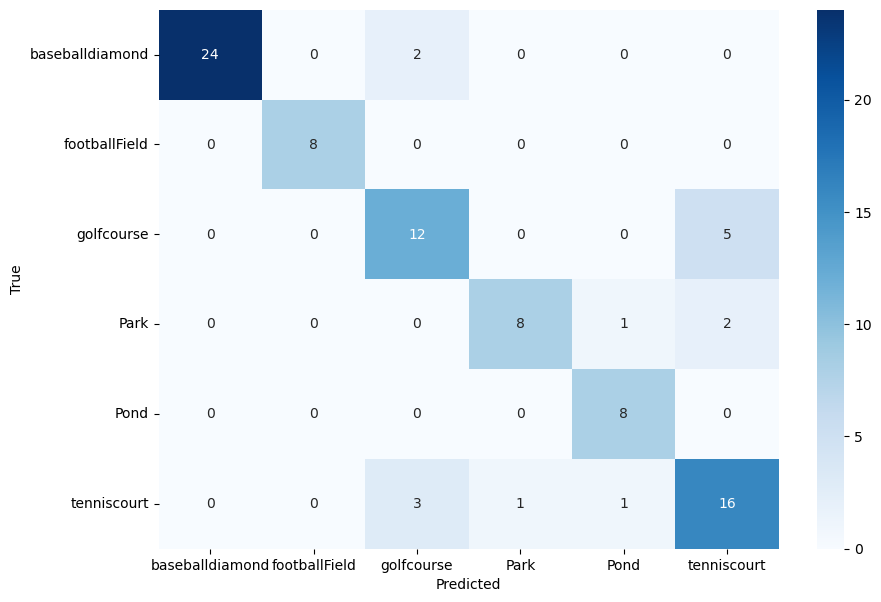

In [9]:
# Calcular la precisión, recall, f1 score y accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
# Supongamos que `model` es tu modelo entrenado
modelo.save('C:/Users/nicol/Desktop/Modelos/WHU/WHU_Custom.h5')

# Entrenamiento con VGG16

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo VGG16 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)  

#******************************************************************************************

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)
#******************************************************************************************




Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.3362 - loss: 2.4049 - val_accuracy: 0.8352 - val_loss: 0.5417 - learning_rate: 0.0010
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.8255 - loss: 0.4755 - val_accuracy: 0.8132 - val_loss: 0.4847 - learning_rate: 0.0010
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.8717 - loss: 0.3110 - val_accuracy: 0.8462 - val_loss: 0.4122 - learning_rate: 0.0010
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.9402 - loss: 0.1710 - val_accuracy: 0.9341 - val_loss: 0.2609 - learning_rate: 9.0484e-04
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9468 - loss: 0.1419 - val_accuracy: 0.9121 - val_loss: 0.3114 - learning_rate: 8.1873e-04
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9571 - loss: 0.1169 - val_accuracy: 0.9011 - val_loss: 0.2995 - learning_rate: 7.4082e-04
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9644 - loss: 0.1079 - va

2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023A49F50D30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
Precision: 0.9404469926209057
Recall: 0.9340659340659341
F1 Score: 0.9346730079022996
Accuracy: 0.9340659340659341
Classification Report:
                 precision    recall  f1-score   support

baseballdiamond       0.96      0.85      0.90        26
  footballField       0.89      1.00      0.94         8
     golfcourse       0.80      0.94      0.86        17
           Park       1.00      0.91      0.95        11
           Pond       1.00      1.00      1.00         8
    tenniscourt       1.00      1.00      1.00        21

       accuracy                           0.93        91
      macro avg       0.94      0.95      0.94        91
   weighted avg       0.94      0.93      0.93        91



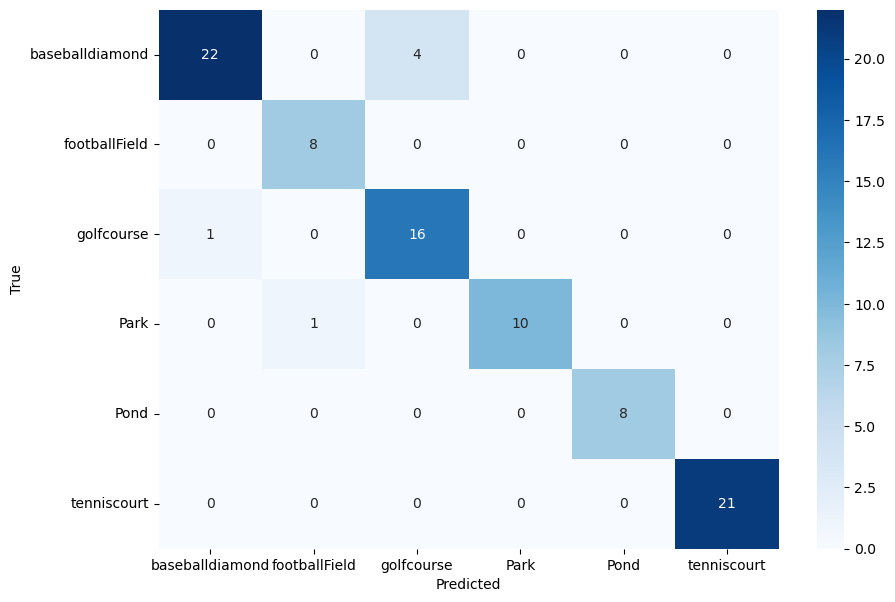

In [12]:
# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/Modelos/WHU/WHU_VGG16.h5')

# Modelo Preentrenado Xception con ImageNet

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo Xception 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)  

#*********************************************************************************************

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.4479 - loss: 6.9956 - val_accuracy: 0.8571 - val_loss: 1.5746 - learning_rate: 0.0010
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.8280 - loss: 1.8759 - val_accuracy: 0.8901 - val_loss: 1.2589 - learning_rate: 0.0010
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.9432 - loss: 0.2962 - val_accuracy: 0.9341 - val_loss: 0.5000 - learning_rate: 0.0010
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.9432 - loss: 0.2291 - val_accuracy: 0.9011 - val_loss: 0.6319 - learning_rate: 9.0484e-04
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.9506 - loss: 0.3029 - val_accuracy: 0.9011 - val_loss: 0.4950 - learning_rate: 8.1873e-04
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.9624 - loss: 0.1189 - val_accuracy: 0.9121 - val_loss: 0.4971 - learning_rate: 7.4082e-04
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.9685 - loss: 0.0914 - va

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
Precision: 0.9358789358789359
Recall: 0.9340659340659341
F1 Score: 0.9340276806709453
Accuracy: 0.9340659340659341
Classification Report:
                 precision    recall  f1-score   support

baseballdiamond       0.93      0.96      0.94        26
  footballField       1.00      0.88      0.93         8
     golfcourse       0.94      0.94      0.94        17
           Park       0.91      0.91      0.91        11
           Pond       1.00      0.88      0.93         8
    tenniscourt       0.91      0.95      0.93        21

       accuracy                           0.93        91
      macro avg       0.95      0.92      0.93        91
   weighted avg       0.94      0.93      0.93        91



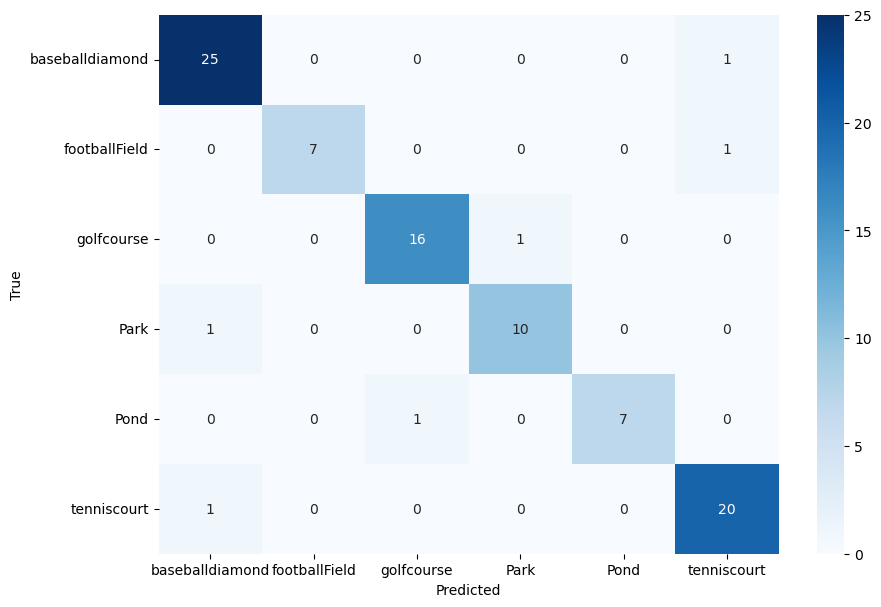

In [15]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names= Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/Modelos/WHU/WHU_Xception.h5')

# Entrenamiento con MobileNet Preentrenado con Imagenet

In [1]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Definir las etiquetas
Etiquetas_Nombres = ['baseballdiamond', 'footballField', 'golfcourse', 'Park', 'Pond', 'tenniscourt']

# Función para cargar imágenes y etiquetas
def cargar_imagenes_con_etiquetas(ruta_dataset, nuevo_tamanio=(256, 256)):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path).convert('RGB')  # Asegurarse de que todas las imágenes estén en RGB
                    img = img.resize(nuevo_tamanio)  # Redimensionar para garantizar que todas tengan el mismo tamaño
                    imagenes.append(np.array(img))  # Convertir a numpy array
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/WHU'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Codificar las etiquetas
codificacion = {'baseballdiamond': 0, 'footballField': 1, 'golfcourse': 2, 'Park': 3, 'Pond': 4, 'tenniscourt': 5}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_codificadas, test_size=0.2, random_state=42)

# Convertir las imágenes a arrays de numpy
X_train_np = np.array(X_train)
height, width, channels = X_train_np.shape[1:]  # Obtener las dimensiones de las imágenes

# Aplanar las imágenes para el sobremuestreo
X_train_2d = X_train_np.reshape(len(X_train_np), -1)

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original después del sobremuestreo
X_train_res = X_train_res_2d.reshape(-1, height, width, channels)

# Definir las transformaciones con normalización y redimensionamiento
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.Resize((256, 256)),  # Redimensionar la imagen
    transforms.ToTensor(),  # Convertir de PIL a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Custom Dataset con transformaciones
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones
        return image, label

# Crear los datasets de entrenamiento y prueba
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

# Crear DataLoaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Entrenamiento y evaluación del modelo
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases (5 en este caso)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cambiar el scheduler a StepLR para reducir cada 3 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Early stopping variables
best_loss = np.Inf
patience = 3
epochs_no_improve = 0
early_stop = False

# Entrenamiento del modelo
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    scheduler.step()
    
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.358895625686273
Validation Loss: 0.3282765820622444
Epoch 2, Loss: 0.16269248854951002
Validation Loss: 0.5626893242200216
Epoch 3, Loss: 0.08570316940313205
Validation Loss: 0.2557776023944219
Epoch 4, Loss: 0.04640205753094051
Validation Loss: 0.03541009003917376
Epoch 5, Loss: 0.020561600977089256
Validation Loss: 0.031147536200781662
Epoch 6, Loss: 0.005141074456332717
Validation Loss: 0.020673710387200117
Epoch 7, Loss: 0.006300720568106044
Validation Loss: 0.023380909735957783
Epoch 8, Loss: 0.023636050820641685
Validation Loss: 0.022167559790735442
Epoch 9, Loss: 0.0064137312801904045
Validation Loss: 0.02311834537734588
Early stopping triggered


Precision: 0.9902319902319903
Recall: 0.989010989010989
F1 Score: 0.9890725520977621
Accuracy: 0.989010989010989
Classification Report:
                 precision    recall  f1-score   support

baseballdiamond       1.00      1.00      1.00        26
  footballField       1.00      1.00      1.00         8
     golfcourse       1.00      1.00      1.00        17
           Park       1.00      0.91      0.95        11
           Pond       0.89      1.00      0.94         8
    tenniscourt       1.00      1.00      1.00        21

       accuracy                           0.99        91
      macro avg       0.98      0.98      0.98        91
   weighted avg       0.99      0.99      0.99        91



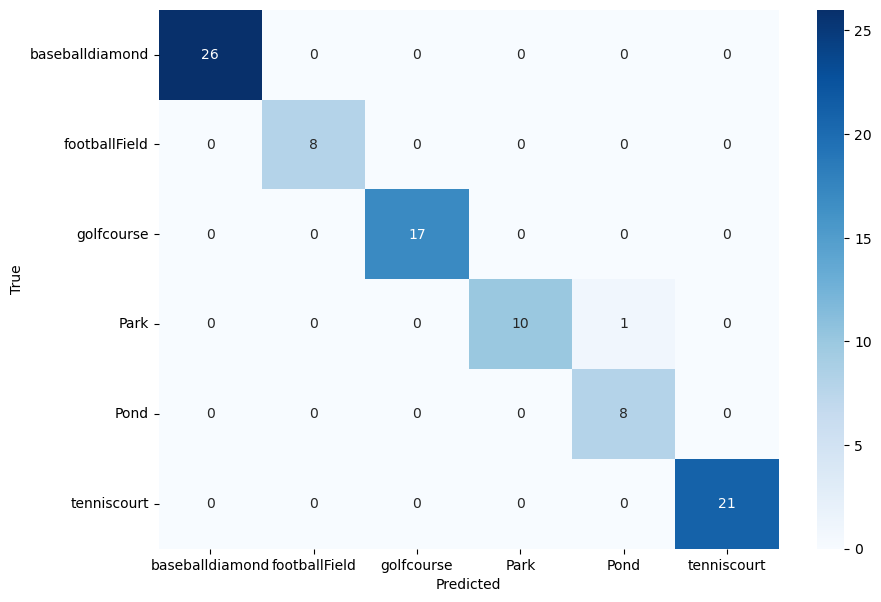

In [3]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluación del modelo
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcular las métricas
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres,
            yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [4]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/Modelos/WHU/WHU_mobileNET.pth')

# Entrenamiento con Resnet18 Preentrenado con Imagenet

In [5]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Definir las etiquetas
Etiquetas_Nombres = ['baseballdiamond', 'footballField', 'golfcourse', 'Park', 'Pond', 'tenniscourt']

# Función para cargar imágenes y etiquetas
def cargar_imagenes_con_etiquetas(ruta_dataset, nuevo_tamanio=(256, 256)):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path).convert('RGB')  # Asegurarse de que todas las imágenes estén en RGB
                    img = img.resize(nuevo_tamanio)  # Redimensionar para garantizar que todas tengan el mismo tamaño
                    imagenes.append(np.array(img))  # Convertir a numpy array
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/WHU'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Codificar las etiquetas
codificacion = {'baseballdiamond': 0, 'footballField': 1, 'golfcourse': 2, 'Park': 3, 'Pond': 4, 'tenniscourt': 5}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_codificadas, test_size=0.2, random_state=42)

# Convertir las imágenes a arrays de numpy
X_train_np = np.array(X_train)
height, width, channels = X_train_np.shape[1:]  # Obtener las dimensiones de las imágenes

# Aplanar las imágenes para el sobremuestreo
X_train_2d = X_train_np.reshape(len(X_train_np), -1)

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original después del sobremuestreo
X_train_res = X_train_res_2d.reshape(-1, height, width, channels)

# Definir las transformaciones con normalización y redimensionamiento
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.Resize((256, 256)),  # Redimensionar la imagen
    transforms.ToTensor(),  # Convertir de PIL a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Custom Dataset con transformaciones
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones
        return image, label

# Crear los datasets de entrenamiento y prueba
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

# Crear DataLoaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Entrenamiento y evaluación del modelo
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo ResNet18 preentrenado
model = models.resnet18(pretrained=True)

# Reemplazar la última capa (fully connected layer) de ResNet18 para adaptarse a nuestro número de clases (5 en este caso)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cambiar el scheduler a StepLR para reducir cada 3 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Early stopping variables
best_loss = np.Inf
patience = 3
epochs_no_improve = 0
early_stop = False

# Entrenamiento del modelo
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    scheduler.step()
    
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.4430088666267693
Validation Loss: 5.859851598739624
Epoch 2, Loss: 0.24093084502965212
Validation Loss: 0.5465258459250132
Epoch 3, Loss: 0.10071576613700017
Validation Loss: 0.2873030702273051
Epoch 4, Loss: 0.04634327083476819
Validation Loss: 0.04598482542981704
Epoch 5, Loss: 0.016492414666572586
Validation Loss: 0.02392288390547037
Epoch 6, Loss: 0.015523740148637444
Validation Loss: 0.023917388170957565
Epoch 7, Loss: 0.008095774086541496
Validation Loss: 0.023159566335380077
Epoch 8, Loss: 0.009198344494507182
Validation Loss: 0.021140515183409054
Epoch 9, Loss: 0.007824163694749586
Validation Loss: 0.0206271189575394
Epoch 10, Loss: 0.00970278651220724
Validation Loss: 0.02387827479590972
Epoch 11, Loss: 0.009272216881072382
Validation Loss: 0.024960206200679142
Epoch 12, Loss: 0.006018301832227735
Validation Loss: 0.024121106291810673
Early stopping triggered


Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
Classification Report:
                 precision    recall  f1-score   support

baseballdiamond       1.00      1.00      1.00        26
  footballField       1.00      1.00      1.00         8
     golfcourse       1.00      1.00      1.00        17
           Park       1.00      1.00      1.00        11
           Pond       1.00      1.00      1.00         8
    tenniscourt       1.00      1.00      1.00        21

       accuracy                           1.00        91
      macro avg       1.00      1.00      1.00        91
   weighted avg       1.00      1.00      1.00        91



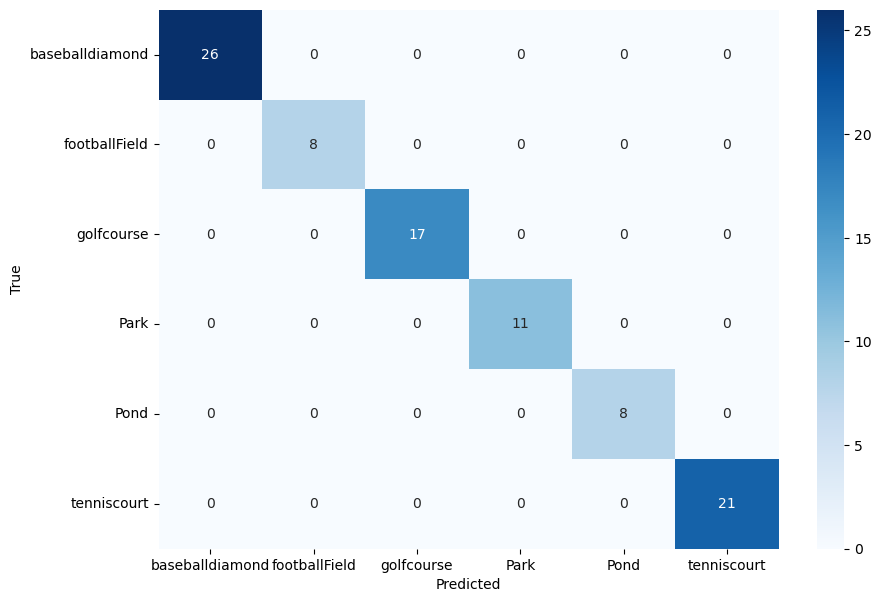

In [6]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluación del modelo
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcular las métricas
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres,
            yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [7]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/Modelos/WHU/WHU_ResNET18.pth')